# **Ground-based cloud classification** using CNNs

<hr>

In [48]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import imageio
from skimage import transform,io
import keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import math
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [49]:
def get_dummies(labels, class_name, index):
    dummy_arr = np.zeros((len(labels)))
    dummy_arr[index] += 1
    return dummy_arr

def load_and_split_data(data_aug_level=0):
    N = 0
    labels = []

    for dirname, _, filenames in os.walk('./train/'):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            splits = dirname.split('/')
            N += 1
            class_name = splits[-1]

            if class_name not in labels and class_name != '': labels.append(splits[-1])

    labels = np.array(labels)

    count = 0

    im_size = 224

    X = np.zeros((N, im_size, im_size, 3))
    y = np.zeros((N, len(labels)))

    for dirname, _, filenames in os.walk('./train/'):
        for filename in filenames:
            if filename == '.DS_Store': continue

            path = os.path.join(dirname, filename)        
            l = path.split('/')[-2]

            im = imageio.imread(path)
            X[count, :, :] = transform.resize(im, (im_size, im_size, 3), mode='symmetric', preserve_range=True)
            y[count, :] = get_dummies(labels, l, np.where(labels == l)[0][0])

            count +=1
    
    
    if data_aug_level >= 1:
        # create data generator
        datagen = ImageDataGenerator(
            width_shift_range=0.15,
            height_shift_range=0.15,
            horizontal_flip=True, # horizontal flip
            brightness_range=[0.95,1.25]) # brightness

        # fit parameters from data
        datagen.fit(X)

        X2 = np.zeros((N, im_size, im_size, 3))
        y2 = np.zeros((N, len(labels)))

        # Configure batch size and retrieve one batch of images
        for X_batch, y_batch in datagen.flow(X, y, batch_size=N):
            for i in range(0, N, 1):
                X2[i,:,:,:] = X_batch[i].reshape(im_size,im_size,3)/255.
                y2[i] = y_batch[i]
            # De esta manera paramos de generar imagenes aleatoriamente
            break
            
        X = np.concatenate((X,X2))
        y = np.concatenate((y,y2))
            
    if data_aug_level >= 2:
        X3 = np.zeros((N, im_size, im_size, 3))
        y3 = np.zeros((N, len(labels)))

        # Configure batch size and retrieve one batch of images
        for X_batch, y_batch in datagen.flow(X, y, batch_size=N):
            for i in range(0, N, 1):
                X3[i,:,:,:] = X_batch[i].reshape(im_size,im_size,3)
                y3[i] = y_batch[i]
            # De esta manera paramos de generar imagenes aleatoriamente
            break
        
        X = np.concatenate((X,X3))
        y = np.concatenate((y,y3))
            
    if data_aug_level >= 3:
        X4 = np.zeros((N, im_size, im_size, 3))
        y4 = np.zeros((N, len(labels)))

        # Configure batch size and retrieve one batch of images
        for X_batch, y_batch in datagen.flow(X, y, batch_size=N):
            for i in range(0, N, 1):
                X4[i,:,:,:] = X_batch[i].reshape(im_size,im_size,3)
                y4[i] = y_batch[i]
            # De esta manera paramos de generar imagenes aleatoriamente
            break
            
        X = np.concatenate((X,X4))
        y = np.concatenate((y,y4))

    if data_aug_level >= 4:
        X5 = np.zeros((N, im_size, im_size, 3))
        y5 = np.zeros((N, len(labels)))

        # Configure batch size and retrieve one batch of images
        for X_batch, y_batch in datagen.flow(X, y, batch_size=N):
            for i in range(0, N, 1):
                X5[i,:,:,:] = X_batch[i].reshape(im_size,im_size,3)
                y5[i] = y_batch[i]
            # De esta manera paramos de generar imagenes aleatoriamente
            break

        X = np.concatenate((X,X5))
        y = np.concatenate((y,y5))
        
    X = preprocess_input(X)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # display some information
    print("X_train shape: ", X_train.shape)
    print("y_train shape: ", y_train.shape)
    print("X_val shape: ", X_val.shape)
    print("y_val shape: ", y_val.shape)
    
    return X_train, X_val, y_train, y_val

In [50]:
X_train, X_val, y_train, y_val = load_and_split_data(data_aug_level=1)

X_train shape:  (3486, 224, 224, 3)
y_train shape:  (3486, 11)
X_val shape:  (1162, 224, 224, 3)
y_val shape:  (1162, 11)


In [51]:
from tensorflow.keras.applications import ResNet152V2, VGG16, MobileNet, EfficientNetB0, MobileNetV2, InceptionResNetV2

pre_trained_model = MobileNetV2(input_shape=(224,224,3),
                         include_top = False,
                         weights='imagenet',
                         classes = 11,
                         classifier_activation='softmax')

# debemos 'congelar' los pesos para hacer el fine tunning 
# y traspasarlos a un nuevo modelo secuencial
for layer in pre_trained_model.layers:
    layer.trainable = False

In [52]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [53]:
activation = "relu"
model = Sequential()
model.add(pre_trained_model)
model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dropout(0.5)) 
model.add(Dense(units=128,activation=activation))
model.add(Dense(units=11, activation="softmax"))

In [54]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         327936    
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12544)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_9 (Dense)              (None, 11)                1419      
Total params: 4,193,099
Trainable params: 1,935,115
Non-trainable params: 2,257,984
____________________________________

In [55]:
class LearningRateDecay:
    def plot(self, epochs, title="Learning Rate Schedule"):
        # compute the set of learning rates for each corresponding
        # epoch
        lrs = [self(i) for i in epochs]
        # the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
        
class StepDecay(LearningRateDecay):
    def __init__(self, initAlpha=1e-5, factor=0.5, dropEvery=10):
        # store the base initial learning rate, drop factor, and
        # epochs to drop every
        self.initAlpha = initAlpha
        self.factor = factor
        self.dropEvery = dropEvery
        
    def __call__(self, epoch):
        # compute the learning rate for the current epoch
        exp = np.floor((1 + epoch) / self.dropEvery)
        alpha = self.initAlpha * (self.factor ** exp)
        
        # return the learning rate
        return float(alpha)

In [57]:
epochs = 50
batch_size = 32 # todo set to 64
steps_per_epoch = len(X_train)//batch_size
validation_steps = len(X_val)//batch_size

In [58]:
initial_lr = 4e-5

#compile model using accuracy to measure model performance
model.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate=initial_lr), metrics=['accuracy'])

In [59]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard

checkpoint = ModelCheckpoint("freezeMobileNet_v11.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
lr_scheduler = LearningRateScheduler(StepDecay(initAlpha=initial_lr, factor=0.5, dropEvery=10), verbose=1)

### 5. Fine tunning of the classifier.

##### Then train

In [60]:
hist_pretrained = model.fit(
    X_train, 
    y_train, 
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, lr_scheduler])

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 4e-05.


2022-03-22 18:36:06.540729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - ETA: 0s - loss: 2.6271 - accuracy: 0.1291

2022-03-22 18:36:18.373648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 16s 144ms/step - loss: 2.6271 - accuracy: 0.1291 - val_loss: 2.3090 - val_accuracy: 0.1641

Epoch 00001: val_accuracy improved from -inf to 0.16406, saving model to freezeMobileNet_v11.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 4e-05.
108/108 [==============================] - 13s 122ms/step - loss: 2.2652 - accuracy: 0.1946 - val_loss: 2.1931 - val_accuracy: 0.2300

Epoch 00002: val_accuracy improved from 0.16406 to 0.23003, saving model to freezeMobileNet_v11.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 4e-05.
108/108 [==============================] - 13s 122ms/step - loss: 2.1573 - accuracy: 0.2328 - val_loss: 2.1307 - val_accuracy: 0.2378

Epoch 00003: val_accuracy improved from 0.23003 to 0.23785, saving model to freezeMobileNet_v11.h5
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 4e-05.
108/108 [==============================] - 13s 116ms/step - loss

KeyboardInterrupt: 

In [46]:
# saving training history (for future visualization)
with open('./train_history_freezeMobileNet_v11.pkl', 'wb') as handle:
    pickle.dump(hist_pretrained.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from tensorflow.keras.models import Model, load_model

saved_model = load_model('freezeMobileNet.h5') 

In [ ]:
X_train, X_val, y_train, y_val = load_and_split_data()

In [ ]:
# debemos 'congelar' los pesos para hacer el fine tunning 
# y traspasarlos a un nuevo modelo secuencial
for layer in saved_model.layers:
    layer.trainable = True

In [ ]:
epochs = 100
batch_size = 32 # todo set to 64
steps_per_epoch = len(X_train)//batch_size
validation_steps = len(X_val)//batch_size

In [ ]:
initial_lr = 1e-3

#compile model using accuracy to measure model performance
saved_model.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate=initial_lr), metrics=['accuracy'])

In [ ]:
#@title Learning rate schedulers
class LearningRateDecay:
    def plot(self, epochs, title="Learning Rate Schedule"):
        # compute the set of learning rates for each corresponding
        # epoch
        lrs = [self(i) for i in epochs]
        # the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
        
class StepDecay(LearningRateDecay):
    def __init__(self, initAlpha=1e-5, factor=0.5, dropEvery=10):
        # store the base initial learning rate, drop factor, and
        # epochs to drop every
        self.initAlpha = initAlpha
        self.factor = factor
        self.dropEvery = dropEvery
        
    def __call__(self, epoch):
        # compute the learning rate for the current epoch
        exp = np.floor((1 + epoch) / self.dropEvery)
        alpha = self.initAlpha * (self.factor ** exp)
        
        # return the learning rate
        return float(alpha)

In [ ]:
checkpoint = ModelCheckpoint("freezeMobileNet_s2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
lr_scheduler = LearningRateScheduler(StepDecay(initAlpha=initial_lr), verbose=1)

In [ ]:
hist_pretrained_s2 = saved_model.fit(
    X_train, 
    y_train, 
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early, lr_scheduler])

### Plot results

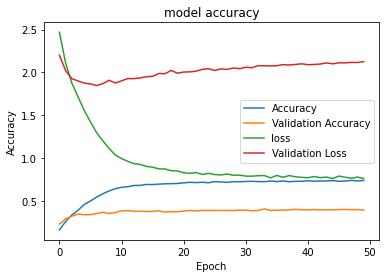

In [47]:
import matplotlib.pyplot as plt
plt.plot(hist_pretrained.history['accuracy'])
plt.plot(hist_pretrained.history['val_accuracy'])
plt.plot(hist_pretrained.history['loss'])
plt.plot(hist_pretrained.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

### AlexNet

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LayerNormalization

# (3) Create a sequential model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())


# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())


# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())


# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())


# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())


# Passing it to a dense layer
model.add(Flatten())


# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))


# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())


# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))

# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

#  output Layer 
model.add(Dense(1000))

model.add(Activation('softmax'))

model.summary()

### Resources

* The dataset used in this notebook is originally from [this link](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/CADDPD/QLLNIJ&version=2.0), which is also used in this [kaggle competition](https://www.kaggle.com/piravinkcm/dastas). Here are more images classified in 5 different classes http://vintage.winklerbros.net/swimcat.html. This last dataset is not equivalent as the first one.

* https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=lpUO9HqUKP6z